This notebook munges the AUC values for the Tumor vs. Normal prediction task and makes several visualizations.

In [1]:
import getpass
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

danieldomingo


In [5]:
print(sys.version)

3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [6]:
print(time.asctime())

Sun May 12 14:33:43 2019


In [7]:
df = pd.read_csv('../../input/tumor_prediction_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.head()

,Database,Dataset,AUC
40,KEGG,BRCA,0.990240
41,KEGG,BRCA,0.993994
42,KEGG,BRCA,1.000000
43,KEGG,BRCA,1.000000
44,KEGG,BRCA,0.995041


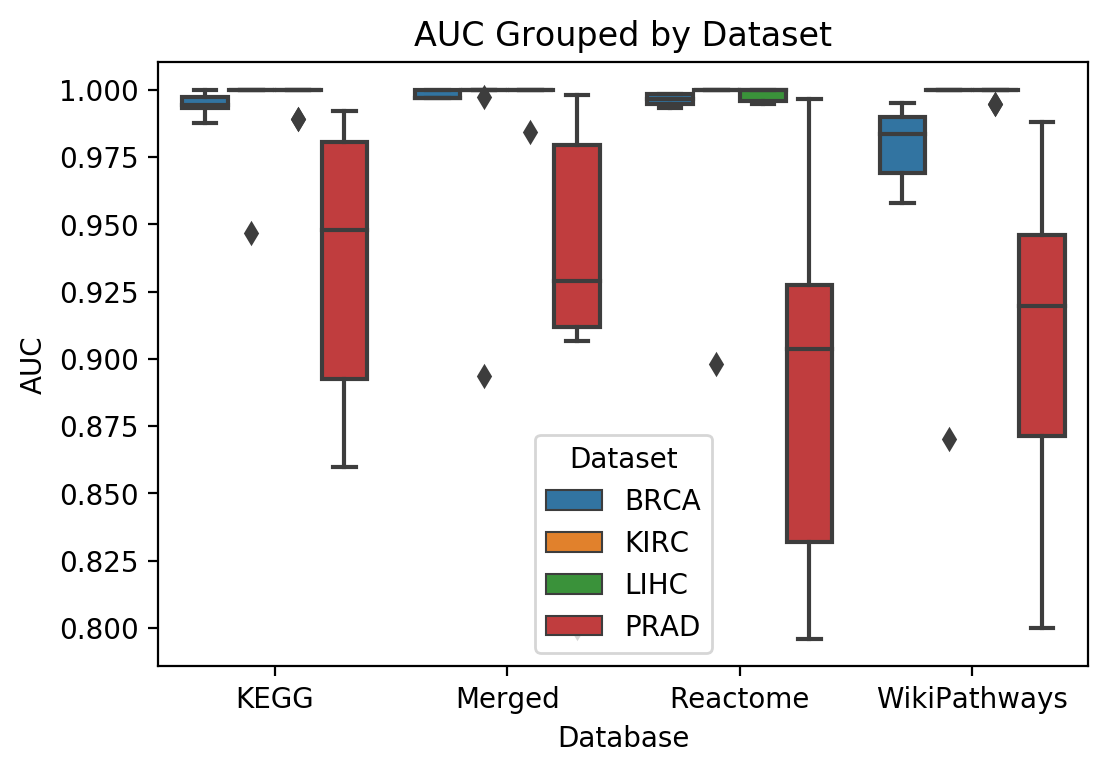

In [8]:
sns.boxplot(
    y='AUC',
    x='Database',
    hue='Dataset',
    data=df
)
plt.title('AUC Grouped by Dataset')
plt.show()

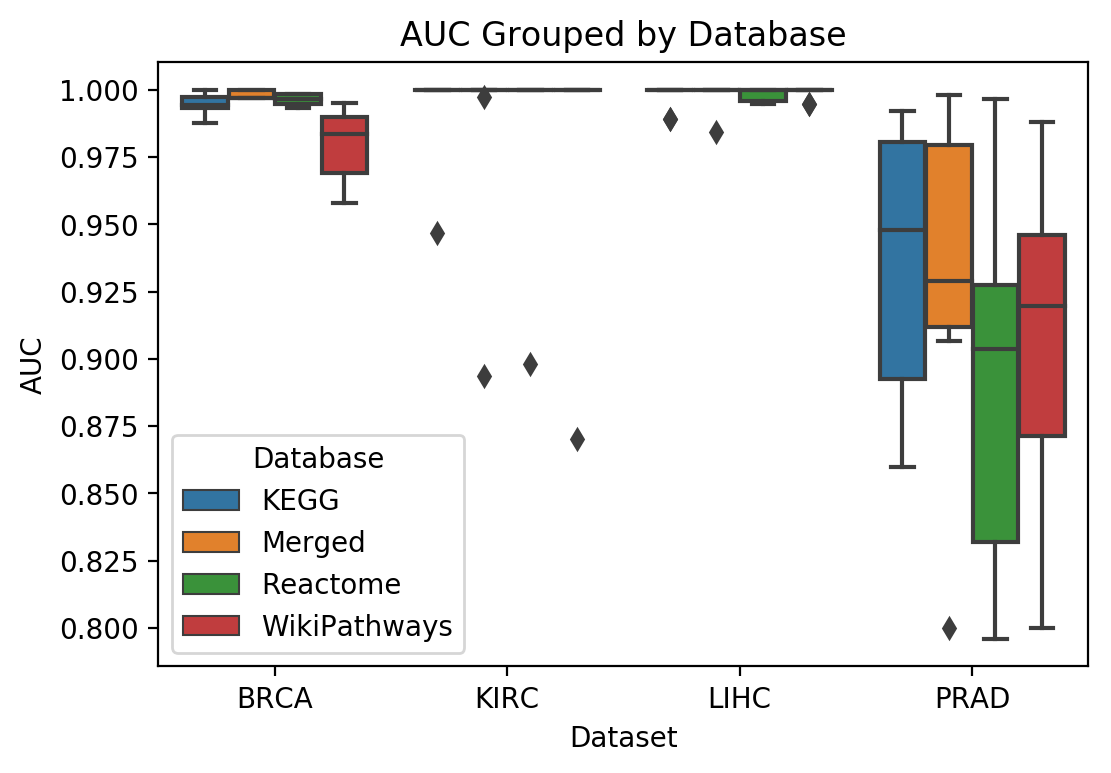

In [9]:
sns.boxplot(
    y='AUC',
    x='Dataset',
    hue='Database',
    data=df
)
plt.title('AUC Grouped by Database')
plt.show()

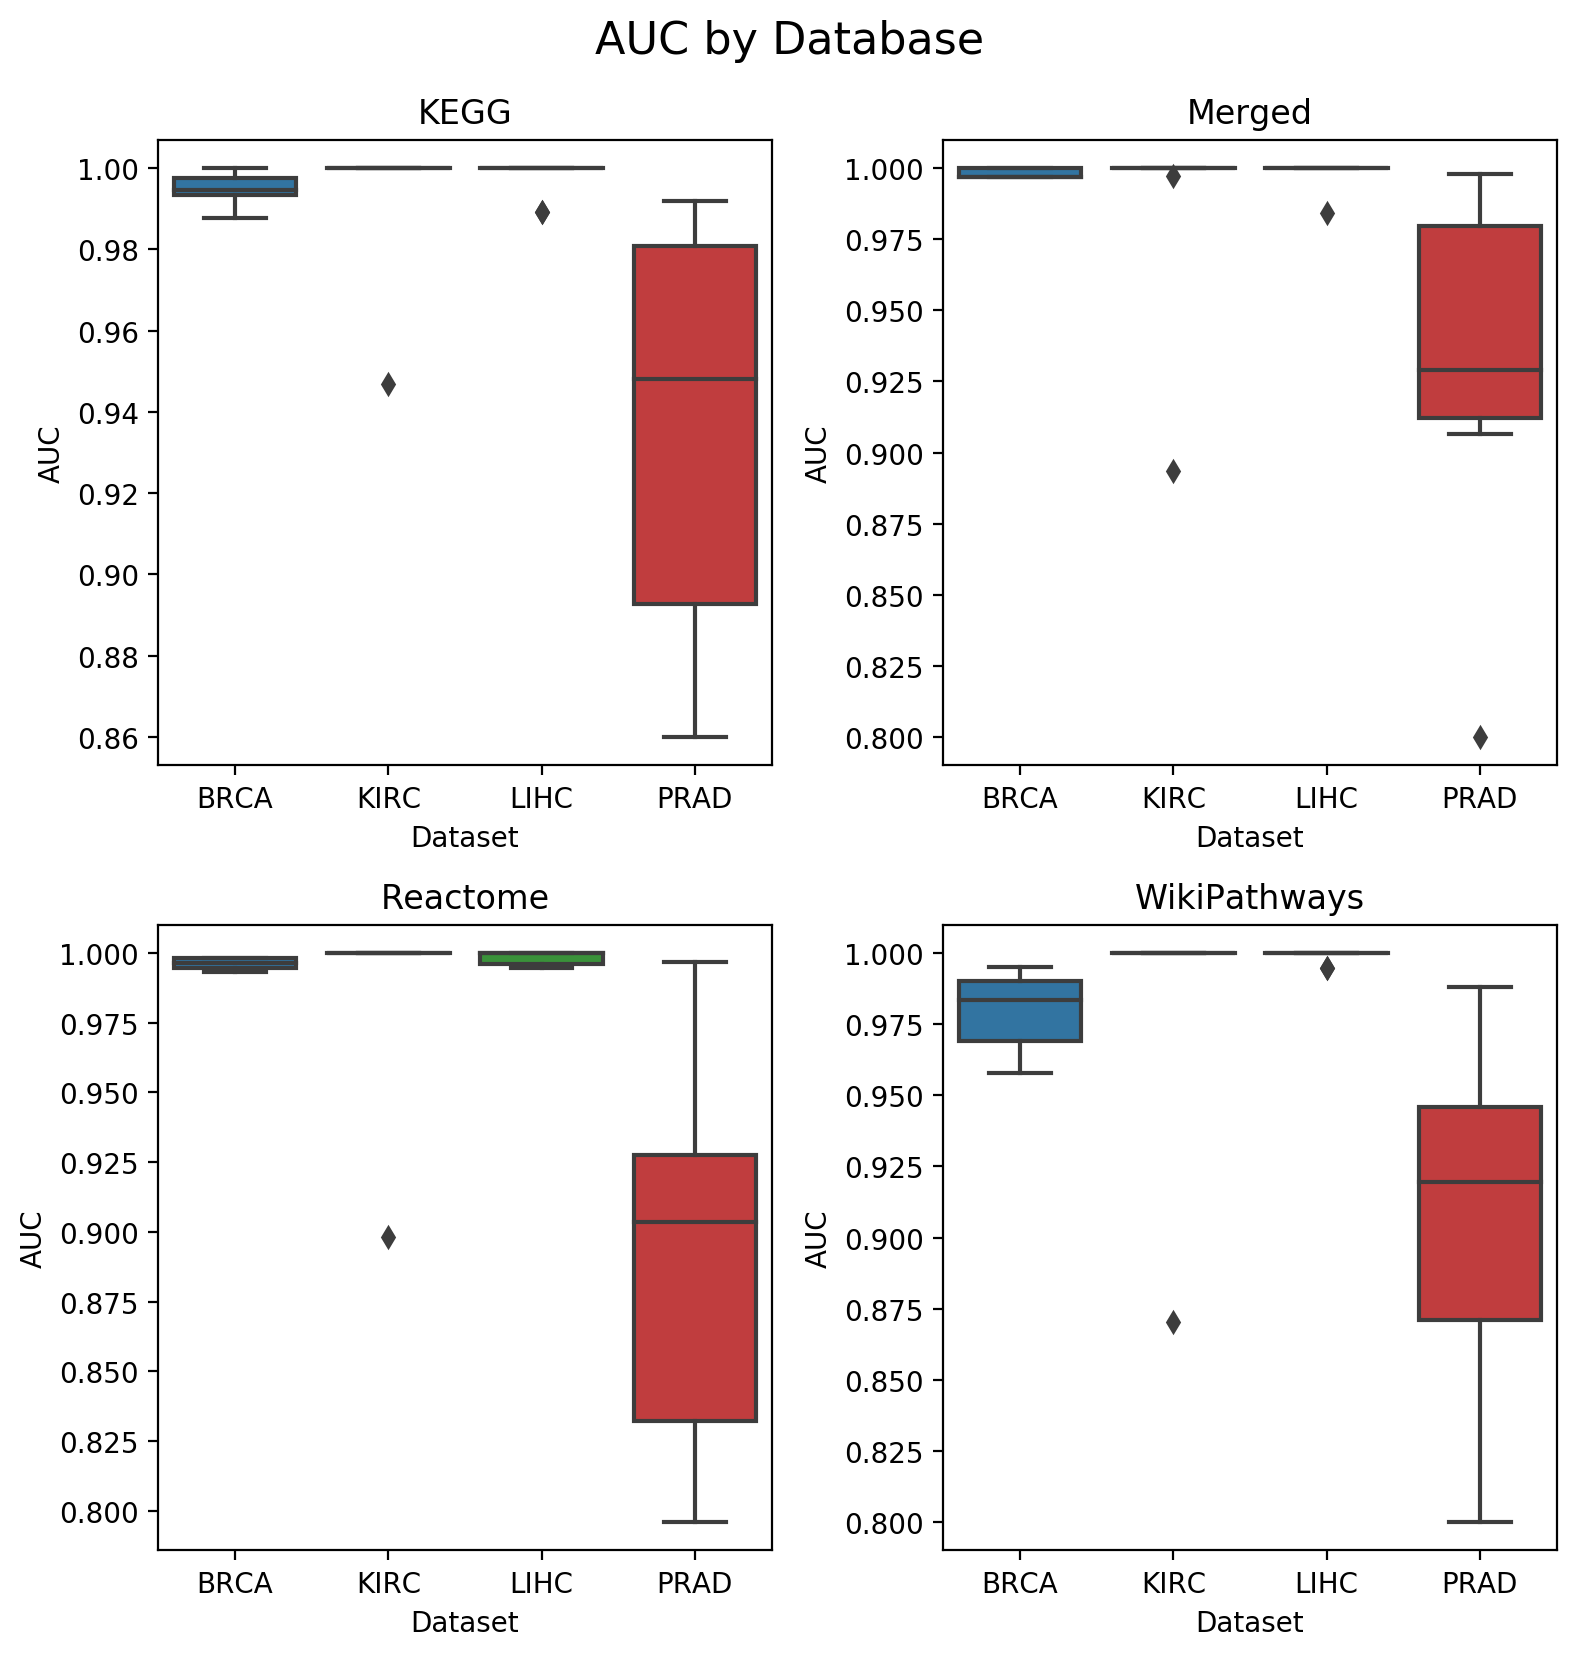

In [10]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

plt.suptitle('AUC by Database', fontsize=16, y=1.03)

y_min = df['AUC'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='AUC',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )

plt.tight_layout()
plt.show()

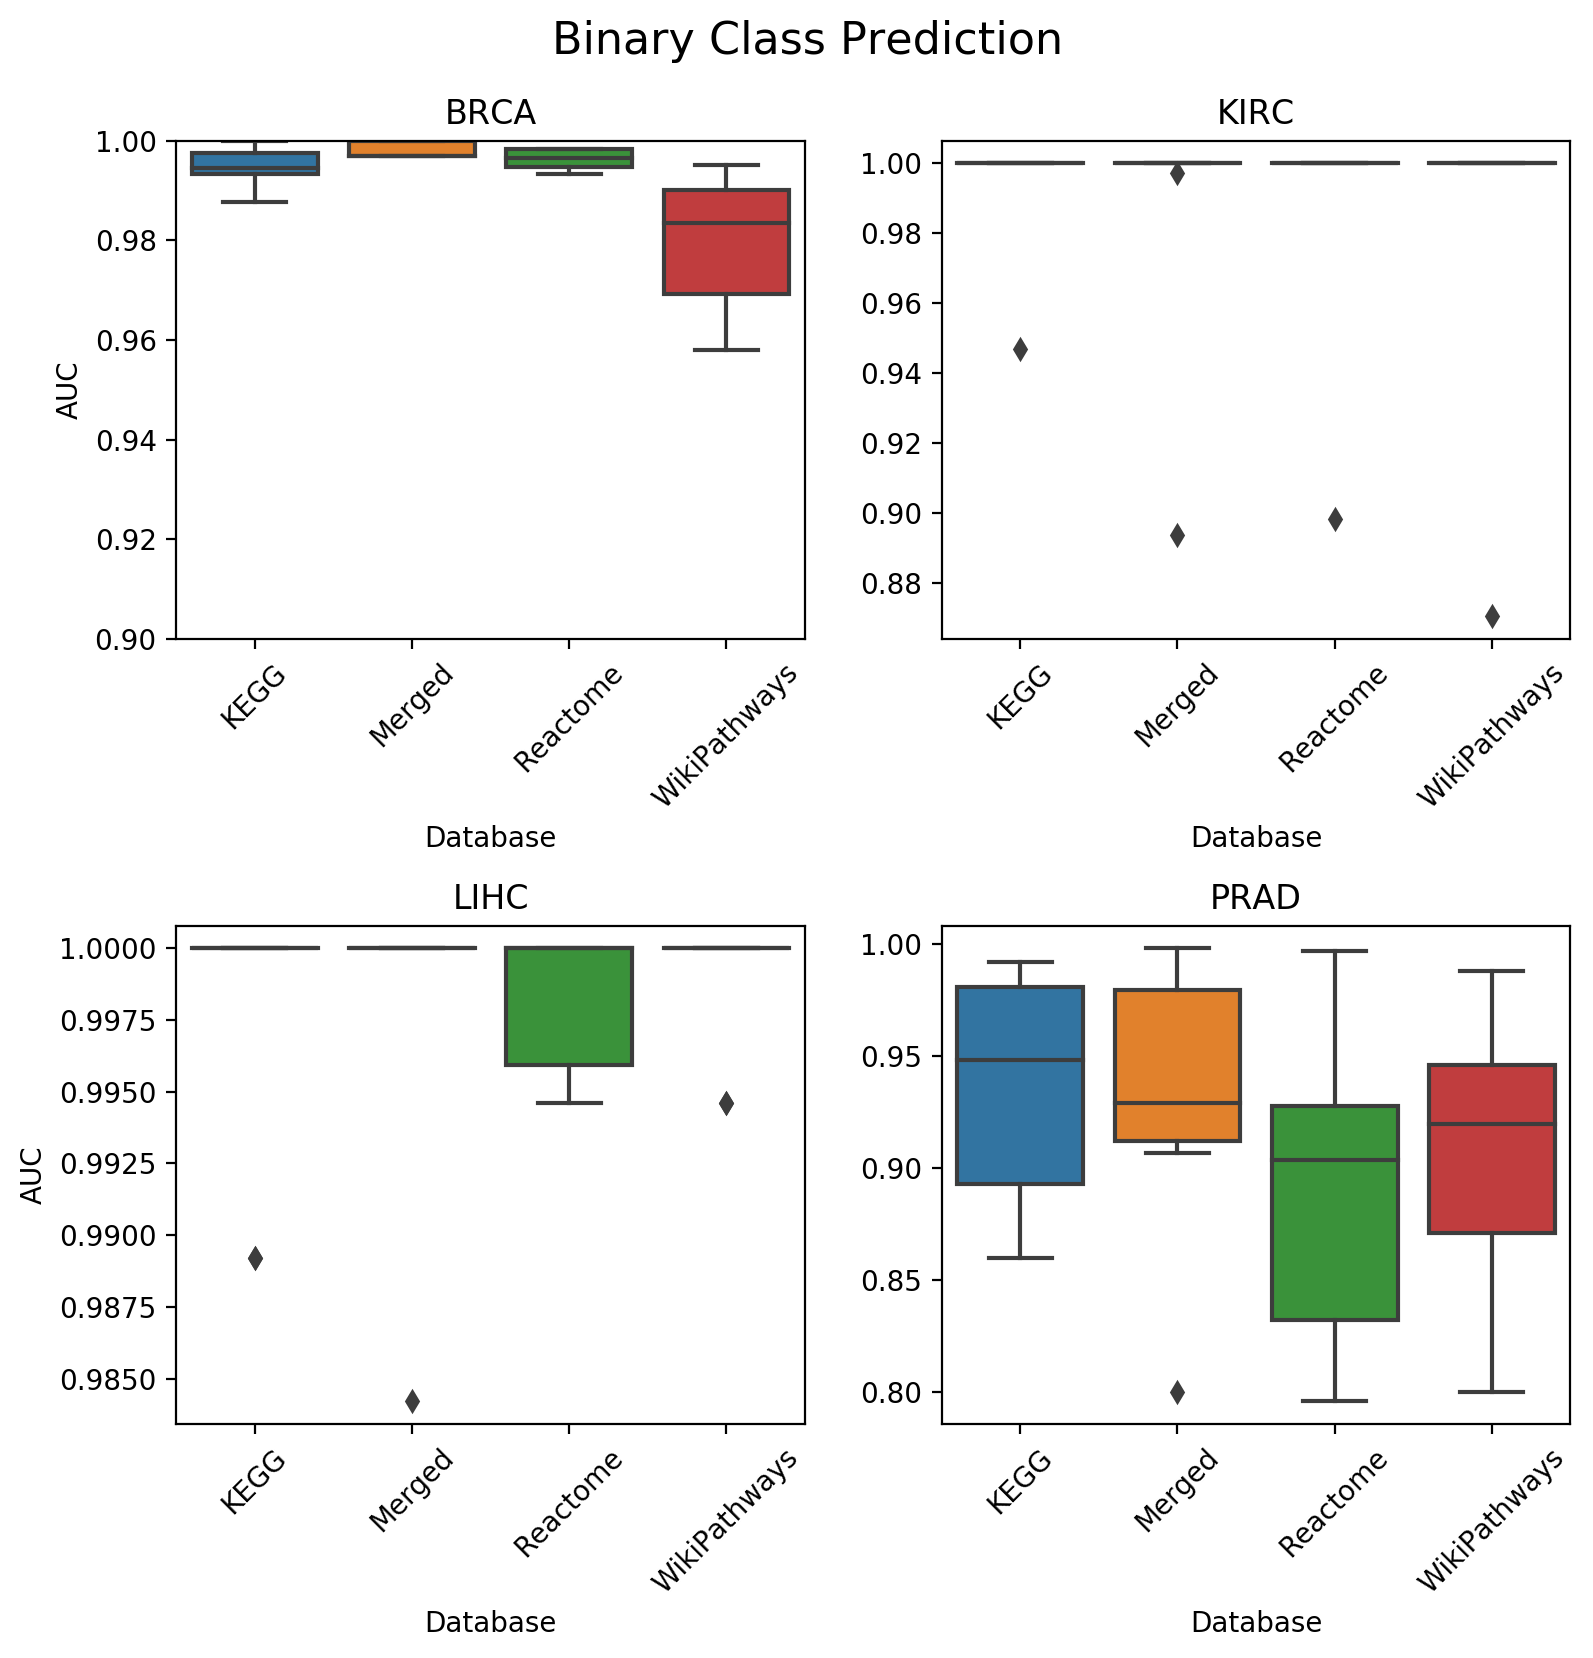

In [11]:
ncols = 2
nrows = df['Dataset'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

plt.suptitle('Binary Class Prediction', fontsize=16, y=1.03)

for plot_number,(dataset, ax) in enumerate(zip(df['Dataset'].unique(), axes.ravel())):
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    if dataset == 'BRCA':
        ax.set_ylim(bottom=0.9, top=1.0) 
        
    sns.boxplot(
        y='AUC',
        x='Database',
        data=df[df['Dataset'] == dataset],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    if plot_number in {1,3}:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()